# Modified TPC-H Q1 Microbenchmark
This file is adapted to use numpy only without Spark.

```sql
select
    min(ps_supplycost)
from
    part,
    partsupp,
    supplier,
    nation,
    region
where
p_partkey = ps_partkey
and s_suppkey = ps_suppkey
and s_nationkey = n_nationkey
and n_regionkey = r_regionkey
and r_name = 'EUROPE'
and partkey=1
```

In [124]:
part_df.head()

,p_partkey,p_name,p_mfgr,p_brand,p_type,p_size,p_container,p_retailprice,p_comment
0,1,goldenrod lavender spring chocolate lace,Manufacturer#1,Brand#13,PROMO BURNISHED COPPER,7,JUMBO PKG,901.00,ironic pinto be
1,2,blush thistle blue yellow saddle,Manufacturer#1,Brand#13,LARGE BRUSHED BRASS,1,LG CASE,902.00,"nding, even pack"
2,3,spring green yellow purple cornsilk,Manufacturer#4,Brand#42,STANDARD POLISHED BRASS,21,WRAP CASE,903.00,ages. blithely fina
3,4,cornflower chocolate smoke green pink,Manufacturer#3,Brand#34,SMALL PLATED BRASS,14,MED DRUM,904.00,ckages. regul
4,5,forest brown coral puff cream,Manufacturer#3,Brand#32,STANDARD POLISHED TIN,15,SM PKG,905.00,pinto beans are


In [125]:
partsupp_df['ps_partkey'].dtypes

dtype('int64')

In [126]:
partsupp_df.head()

,ps_partkey,ps_suppkey,ps_availqty,ps_supplycost,ps_comment
0,1,2,3325,771.64,blithely regular theodolites sleep slyly acros...
1,1,252,8076,993.49,"ts boost carefully ironic, regular accounts. f..."
2,1,502,3956,337.09,fluffily regular multipliers? sheaves integra...
3,1,752,4069,357.84,press deposits. special courts about the slyly...
4,2,3,8895,378.49,sits. furiously regular packages boost blithel...


In [127]:
supplier_df.head()

,s_suppkey,s_name,s_address,s_nationkey,s_phone,s_acctbal,s_comment
0,1,Supplier#000000001,"sdrGnXCDRcfriBvY0KL,ipCanOTyK t NN1",17,27-918-335-1736,5755.94,instructions. slyly unusual
1,2,Supplier#000000002,TRMhVHz3XiFuhapxucPo1,5,15-679-861-2259,4032.68,the pending packages. furiously expres
2,3,Supplier#000000003,BZ0kXcHUcHjx62L7CjZSql7gbWQ6RPn5X,1,11-383-516-1199,4192.40,ong the fluffily idle packages: bold foxes mol...
3,4,Supplier#000000004,qGTQJXogS83a7MBnEweGHKevK,15,25-843-787-7479,4641.08,al braids affix through the regular
4,5,Supplier#000000005,lONEYAh9sFWAF75tO,11,21-151-690-3663,-283.84,accounts. instructions ha


In [130]:
EXPERIMENT = 'pac-q2-min'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True
USE_EVEN_NUMBER_OF_INPUT_ROWS = False
SEED_RANDOM_NUMBER_GENERATOR = True

SAMPLING_METHOD = 'poisson' # 'poisson' or 'half'

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENERATE = True, so we will generate new samples.


### Running PAC

In [131]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
if SEED_RANDOM_NUMBER_GENERATOR:
    np.random.seed(0)

import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator
from IPython.display import display, HTML
from datetime import date

In [132]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [133]:
### Data Setup
nation_df = pd.read_parquet('./data/tpch/nation.parquet')
region_df = pd.read_parquet('./data/tpch/region.parquet')
partsupp_df = pd.read_parquet('./data/tpch/partsupp.parquet')
supplier_df = pd.read_parquet('./data/tpch/supplier.parquet')
part_df = pd.read_parquet('./data/tpch/part.parquet')

In [134]:
def runquery(join_df: DataFrame) -> int:
    print(len(join_df))
    
    aggregated_result = [float(join_df['ps_supplycost'].min())]

    print(aggregated_result)

    return aggregated_result
runquery(nation_df, region_df, partsupp_df, supplier_df, part_df)

TypeError: runquery() takes 1 positional argument but 5 were given

In [74]:
### Query Setup
SAMPLES = 8192
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

OUTPUT_COLS = ['min_ps_supplycost']

true_result = runquery(nation_df, region_df, partsupp_df, supplier_df, part_df)


number_of_contributing_rows = 16320  # hardcode number of eligible rows

def poisson_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select a subset of indices, where each index is selected with probability 0.5.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    mask = np.random.random_sample(len(df)) < 0.5  # Generates a bitmask of length df.shape[0] where each bit is 1 with probability 0.5
    selected = df[mask]
    not_selected = df[~mask]
    return selected, not_selected

def half_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select half of the row indices from the dataframe at random.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = np.random.choice(df.index, size=(df.shape[0] // 2), replace=False)
    not_indices = list(set(df.index) - set(indices))
    selected: DataFrame = df.loc[indices]
    not_selected: DataFrame = df.loc[not_indices]
    return (selected, not_selected)

def sample_using_chosen_method(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    if SAMPLING_METHOD == 'poisson':
        return poisson_paired_sample(df)
    elif SAMPLING_METHOD == 'half':
        return half_paired_sample(df)

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # Apply thresholding: if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)

    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    number_of_pairs = SAMPLES // 2
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        print(f'iteration : {i}')
        europe_region = region_df[region_df['r_name'] == 'EUROPE']
        nation_region = pd.merge(nation_df, europe_region, left_on='n_regionkey', right_on='r_regionkey')
        supplier_nation = pd.merge(supplier_df, nation_region, left_on='s_nationkey', right_on='n_nationkey')
        joined = pd.merge(partsupp_df, supplier_nation, left_on='ps_suppkey', right_on='s_suppkey')
        full_join = pd.merge(joined, part_df, left_on='ps_partkey', right_on='p_partkey')

        full_join = full_join[full_join['ps_partkey'] == 1]

        for temp_df in sample_using_chosen_method(full_join.reset_index(drop=True)):  # reset index to sequential
            out = runquery(nation_df, region_df, partsupp_df, temp_df, part_df)
            # double the sums and counts, avg stays the same
            # out[0] *= 2

            # for a 2d array, flatten it
            out_np.append(np.array(out))

    return out_np

16320
[1.01]


In [75]:
### Compute PAC Noise
def get_pac_noise_scale(out_np_raw: List[np.ndarray],
                           max_mi: float = 1./4) -> np.ndarray:
    if out_np_raw is None or len(out_np_raw) == 0:
        raise ValueError("Input list out_np cannot be empty.")
    out_np = out_np_raw.copy()
    # print(out_np)
    dimensions: int = len(out_np[0])
    print(f'The dimensions are - {dimensions}')

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays
    print(out_np_2darr)
    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, len(out_np))  # shape (dimensions, samples)
    print(f"est_y.shape: {est_y.shape}")
    print(f"est_y: {est_y}")

    # get the scale in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    print(f"fin_var: {fin_var}")
    # fin_var: np.ndarray = np.array([float(x) for x in fin_var], dtype=np.float64)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))
    print(f"sqrt_total_var: {sqrt_total_var}")

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # scale of the PAC noise
    print(f"For mi={max_mi}, we should add noise from a normal distribution with scale...")
    print(f"\t{1./(2*max_mi)} * {sqrt_total_var} * {np.sqrt(fin_var)} = {pac_noise}")
    print(f"pac_noise: {pac_noise}")
    return pac_noise

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4,
                       scale: np.ndarray = None,
                       chosen_index: int = None) -> np.ndarray:
    
    if scale is not None:
        pac_noise: np.ndarray = scale
    else:
        pac_noise = get_pac_noise_scale(out_np, max_mi)

    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    if chosen_index is None:  # allow for overriding the chosen index to specify which sample to use for the release
        chosen_index = np.random.choice(range(SAMPLES))
    pac_release = out_np[chosen_index] + pac_noises_to_add
    
    return pac_release

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [76]:
MI_OPTIONS = [0.001248318631131131, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]
EXPERIMENTS = 1000

if GENERATE:
    experiment_results = []
    saved_steps = []

    out_np = generate_samples() # generate samples (results of running the query)
    print(f"Generate samples... {len(out_np)} samples generated.")

    for mi in MI_OPTIONS:
        print("Getting PAC Noise...")
        scale = get_pac_noise_scale(out_np, mi) # estimate the stability of the query
        print(f"mi={mi}, scale={scale}")
        
        for e in range(EXPERIMENTS):
            # for each PAC release at this MI, we will choose a sample from the pre-generated out_np list and add noise to it
            steps = {
                "mi": mi,
                "scale": scale,
            }

            # choose our sample
            chosen_index = np.random.choice(range(SAMPLES))
            chosen_sample = out_np[chosen_index].copy()
            steps["chosen_sample"] = chosen_sample
            
            # add noise to it
            # chosen_noise will also be an array
            
            chosen_noise = np.random.normal(loc=0, scale=np.sqrt(scale))
            steps["chosen_noise"] = chosen_noise
            
            print(f'Chosen Sample {chosen_sample}')
            # chosen_sample = np.array([float(x) for x in chosen_sample], dtype=np.float64)
            release = chosen_sample + chosen_noise # do_pac_and_release(out_np, mi, scale, chosen_index)

            #print(f"sample(#{chosen_index}):{chosen_sample} + noise:{chosen_noise} = {release}")
            steps["release"] = release
            #release[0] *= 2   # manually correct count = count * 2

            # manually add sum as count * mean
            #noisy_output = [noisy_output[0], noisy_output[0] * noisy_output[1], noisy_output[1]]
            #chosen_sample = [chosen_sample[0], chosen_sample[0] * chosen_sample[1], chosen_sample[1]]
            experiment_results.append([mi, *release])
            saved_steps.append(steps)
    
    df = pd.DataFrame(experiment_results, columns=['mi', *OUTPUT_COLS])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
        pickle.dump(experiment_results, f)
    with open(f'{OUTPUT_DIR}/saved_steps.pkl', 'wb') as f:
        pickle.dump(saved_steps, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
        experiment_results = pickle.load(f)
    with open(f'{OUTPUT_DIR}/saved_steps.pkl', 'rb') as f:
        saved_steps = pickle.load(f)

# df.head()

iteration : 0
8240
[1.07]
8080
[1.01]
iteration : 1
7920
[1.34]
8400
[1.01]
iteration : 2
8880
[1.01]
7440
[1.34]
iteration : 3
8080
[1.03]
8240
[1.01]
iteration : 4
8720
[1.01]
7600
[1.05]
iteration : 5
8560
[1.01]
7760
[1.03]
iteration : 6
8720
[1.01]
7600
[1.03]
iteration : 7
8880
[1.01]
7440
[1.03]
iteration : 8
8080
[1.01]
8240
[1.03]
iteration : 9
8560
[1.01]
7760
[1.03]
iteration : 10
7680
[1.07]
8640
[1.01]
iteration : 11
8480
[1.38]
7840
[1.01]
iteration : 12
7280
[1.01]
9040
[1.03]
iteration : 13
7440
[1.03]
8880
[1.01]
iteration : 14
8400
[1.01]
7920
[1.03]
iteration : 15
9520
[1.01]
6800
[1.34]
iteration : 16
8240
[1.01]
8080
[1.05]
iteration : 17
9040
[1.01]
7280
[1.03]
iteration : 18
8160
[1.21]
8160
[1.01]
iteration : 19
7360
[1.03]
8960
[1.01]
iteration : 20
7200
[1.05]
9120
[1.01]
iteration : 21
7920
[1.01]
8400
[1.05]
iteration : 22
7920
[1.01]
8400
[1.05]
iteration : 23
7920
[1.01]
8400
[1.03]
iteration : 24
6800
[1.03]
9520
[1.01]
iteration : 25
7760
[1.05]
8560
[1.

In [77]:
saved_steps_df_temp = pd.DataFrame(saved_steps)
saved_steps_df_temp.head()

,mi,scale,chosen_sample,chosen_noise,release
0,0.001248,[1.933273783006422],[1.01],[-0.46467326206261783],[0.5453267379373822]
1,0.001248,[1.933273783006422],[1.05],[3.3467886476774287],[4.396788647677429]
2,0.001248,[1.933273783006422],[1.05],[0.042378069035329834],[1.09237806903533]
3,0.001248,[1.933273783006422],[1.01],[-0.27367248041174513],[0.7363275195882548]
4,0.001248,[1.933273783006422],[1.03],[0.5454713776692781],[1.5754713776692781]


In [78]:
### Reconstruct Saved Steps
# Get list of keys from the first dict, excluding 'mi' since it's not a list
steps = [k for k in saved_steps[0].keys() if k not in ('mi')] # pull keys from saved_steps[0]

saved_steps_df_temp = pd.DataFrame(saved_steps)

# Create expanded columns using comprehension
expanded = {
    'mi': saved_steps_df_temp['mi'],
    **{f'{step}_{col}': saved_steps_df_temp[step].str[i] 
        for step in steps
        for i, col in enumerate(OUTPUT_COLS)}
}

# Create MultiIndex DataFrame using OUTPUT_COLS
saved_steps_df = pd.DataFrame(expanded)
saved_steps_df.columns = pd.MultiIndex.from_tuples([('mi',''), *[  # multiindex so that we can do things like saved_steps_df['release'][<aggregation>]
    (step, col) for step in steps for col in OUTPUT_COLS
]], names=["step", "query"])
saved_steps_df.head()

step,mi,scale,chosen_sample,chosen_noise,release
query,,min_ps_supplycost,min_ps_supplycost,min_ps_supplycost,min_ps_supplycost
0,0.001248,1.933274,1.01,-0.464673,0.545327
1,0.001248,1.933274,1.05,3.346789,4.396789
2,0.001248,1.933274,1.05,0.042378,1.092378
3,0.001248,1.933274,1.01,-0.273672,0.736328
4,0.001248,1.933274,1.03,0.545471,1.575471


In [79]:
saved_steps_df.groupby('mi').mean()

/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_69015/2569112584.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df.groupby('mi').mean()


step,scale,chosen_sample,chosen_noise,release
query,min_ps_supplycost,min_ps_supplycost,min_ps_supplycost,min_ps_supplycost
mi,,,,
0.001248,1.933274,1.04402,0.036522,1.080542
0.015625,0.154454,1.04422,-0.028433,1.015787
0.031250,0.077227,1.04076,-0.008073,1.032687
0.062500,0.038613,1.03852,0.003546,1.042066
0.250000,0.009653,1.03751,0.007032,1.044542
1.000000,0.002413,1.04250,-0.001464,1.041036
2.000000,0.001207,1.04214,-0.000156,1.041984
4.000000,0.000603,1.03775,0.000557,1.038307


<Axes: >

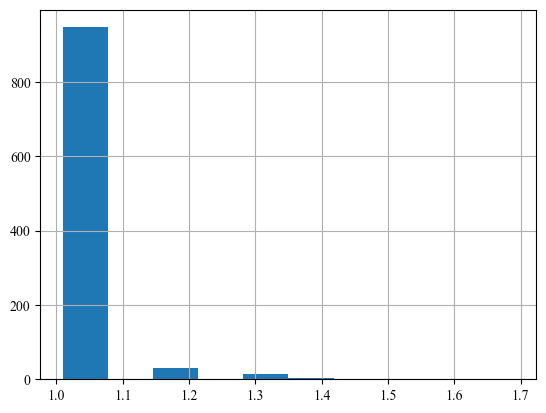

In [80]:
saved_steps_df[saved_steps_df['mi'] == 1/4]['chosen_sample']['min_ps_supplycost'].hist()

In [81]:
if ('mean' in OUTPUT_COLS):
    print("Mean of chosen_sample['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['chosen_sample']['mean'].hist()

In [82]:
if ('mean' in OUTPUT_COLS):
    print("Mean of release['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['release']['mean'].hist()

In [83]:
### DEBUG: Save the variables from computing the PAC noises for later reverse engineering
#if GENERATE:
#    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['mi', 'out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
#    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
#else:
#    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
#saved_pac_variables_df.head()

### Computing PAC Errors

In [84]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [85]:
#OUTPUT_COLS = OUTPUT_COLS
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

In [86]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        print(row)
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

mi                   0.001248
min_ps_supplycost    0.545327
Name: 0, dtype: float64
mi                   0.001248
min_ps_supplycost    4.396789
Name: 1, dtype: float64
mi                   0.001248
min_ps_supplycost    1.092378
Name: 2, dtype: float64
mi                   0.001248
min_ps_supplycost    0.736328
Name: 3, dtype: float64
mi                   0.001248
min_ps_supplycost    1.575471
Name: 4, dtype: float64
mi                   0.001248
min_ps_supplycost   -0.299806
Name: 5, dtype: float64
mi                   0.001248
min_ps_supplycost    0.141489
Name: 6, dtype: float64
mi                   0.001248
min_ps_supplycost    2.418607
Name: 7, dtype: float64
mi                   0.001248
min_ps_supplycost   -1.256332
Name: 8, dtype: float64
mi                   0.001248
min_ps_supplycost    0.363058
Name: 9, dtype: float64
mi                   0.001248
min_ps_supplycost    2.571426
Name: 10, dtype: float64
mi                   0.001248
min_ps_supplycost    1.345570
Name: 11, dtype

,mi,absolute error min_ps_supplycost,relative error min_ps_supplycost
0,0.001248,0.464673,46.007254
1,0.001248,3.386789,335.325609
2,0.001248,0.082378,8.156244
3,0.001248,0.273672,27.096285
4,0.001248,0.565471,55.987265
...,...,...,...
8995,16.000000,0.029633,2.933948
8996,16.000000,0.011398,1.128523
8997,16.000000,0.007562,0.748663
8998,16.000000,0.424715,42.050973


In [87]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Computing DP Errors

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [88]:
%%script echo skipping# Import Chais saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"{OUTPUT_DIR}/dp-q4/dp_results.parquet").to_pandas()

# compute sum from count and mean
dp_results_df['sum'] = dp_results_df['count'] * dp_results_df['mean']
dp_results_df = dp_results_df[['mi', 'count', 'sum', 'mean']]

# filter to just MI_OPTIONS
dp_results_df = dp_results_df[dp_results_df['mi'].isin(MI_OPTIONS)]

dp_results_df

skipping# Import Chais saved data from running PipelineDP and use it to compare.


In [89]:
%%script echo skipping# compute errors for DP (or import from saved file)
GENERATE_DP = True
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    dp_errors_df.to_parquet(f"{OUTPUT_DIR}/dp-q4/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"{OUTPUT_DIR}/dp-q4/dp_errors.parquet").to_pandas()
dp_errors_df

skipping# compute errors for DP (or import from saved file)


In [90]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}), # switch from eps to mi for indexing DP results
    #dp_results_df.assign(type='dp').rename(columns={'mi': 'factor'}), # comment out DP results until we have some
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
#all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")  # Save the merged results
all_df

min_ps_supplycost mean  min_ps_supplycost var
type factor                                                  
pac  0.001248                 1.080542               1.849987
     0.015625                 1.015787               0.166472
     0.031250                 1.032687               0.081921
     0.062500                 1.042066               0.041129
     0.250000                 1.044542               0.013485
     1.000000                 1.041036               0.007702
     2.000000                 1.041984               0.007052
     4.000000                 1.038307               0.004710
     16.000000                1.043935               0.006171

In [91]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), # switch from eps to mi for indexing DP results
    #dp_errors_df.assign(type='dp').rename(columns={'mi': 'factor'}), # comment out DP results until we have some
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
#errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

#errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error min_ps_supplycost mean  \
type factor                                             
pac  0.001248                                1.083888   
     0.015625                                0.326756   
     0.031250                                0.228871   
     0.062500                                0.163233   
     0.250000                                0.090542   
     1.000000                                0.059175   
     2.000000                                0.049222   
     4.000000                                0.039316   
     16.000000                               0.038747   

                absolute error min_ps_supplycost var  \
type factor                                            
pac  0.001248                               0.678979   
     0.015625                               0.059629   
     0.031250                               0.030002   
     0.062500                               0.015487   
     0.250000                               0.006473   
     1.000000                               0.005161   
     2.000000                               0.005651   
     4.000000                               0.003965   
     16.000000                              0.005821   

                relative error min_ps_supplycost mean  \
type factor                                             
pac  0.001248                              107.315658   
     0.015625                               32.352095   
     0.031250                               22.660462   
     0.062500                               16.161698   
     0.250000                                8.964530   
     1.000000                                5.858895   
     2.000000                                4.873486   
     4.000000                                3.892697   
     16.000000                               3.836343   

                relative error min_ps_supplycost var  
type factor                                           
pac  0.001248                            6656.003245  
     0.015625                             584.544266  
     0.031250                             294.107526  
     0.062500                             151.816935  
     0.250000                              63.456060  
     1.000000                              50.594581  
     2.000000                              55.395887  
     4.000000                              38.867625  
     16.000000                             57.065459

In [92]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [93]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [94]:
import matplotlib.colors as mcolors

PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# Function to lighten a color by blending with white
def lighten_color(color, amount=0.3):
    rgba = mcolors.to_rgba(color)
    return tuple(np.clip(np.array(rgba[:3]) + amount, 0, 1)) + (rgba[3],)

# Create lighter colors
PAC_LIGHT = lighten_color(PAC_COLOR, 0.3)
DP_LIGHT = lighten_color(DP_COLOR, 0.3)

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

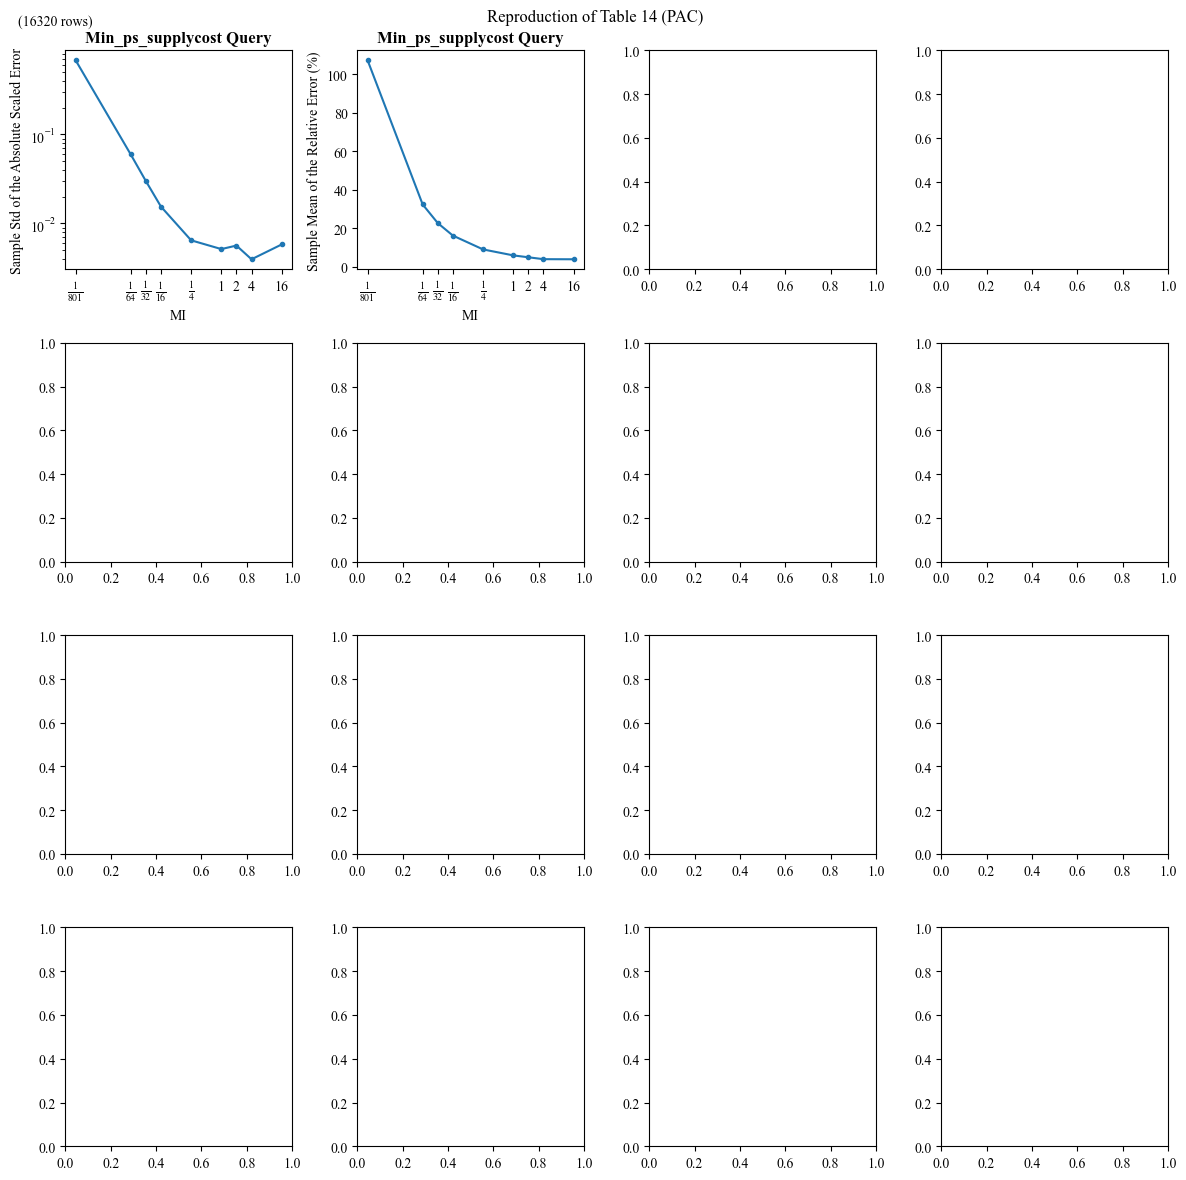

In [95]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')

    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.95, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

In [96]:
%%script echo skipping### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    
    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

skipping### Reproduction of Table 14 (DP)


Both on the same axes, aligned

In [97]:
%%script echo skipping
### Both on the same axes, aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    #print(d)
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('MI')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    
    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('MI')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

skipping


# Additonal Extra Plotting

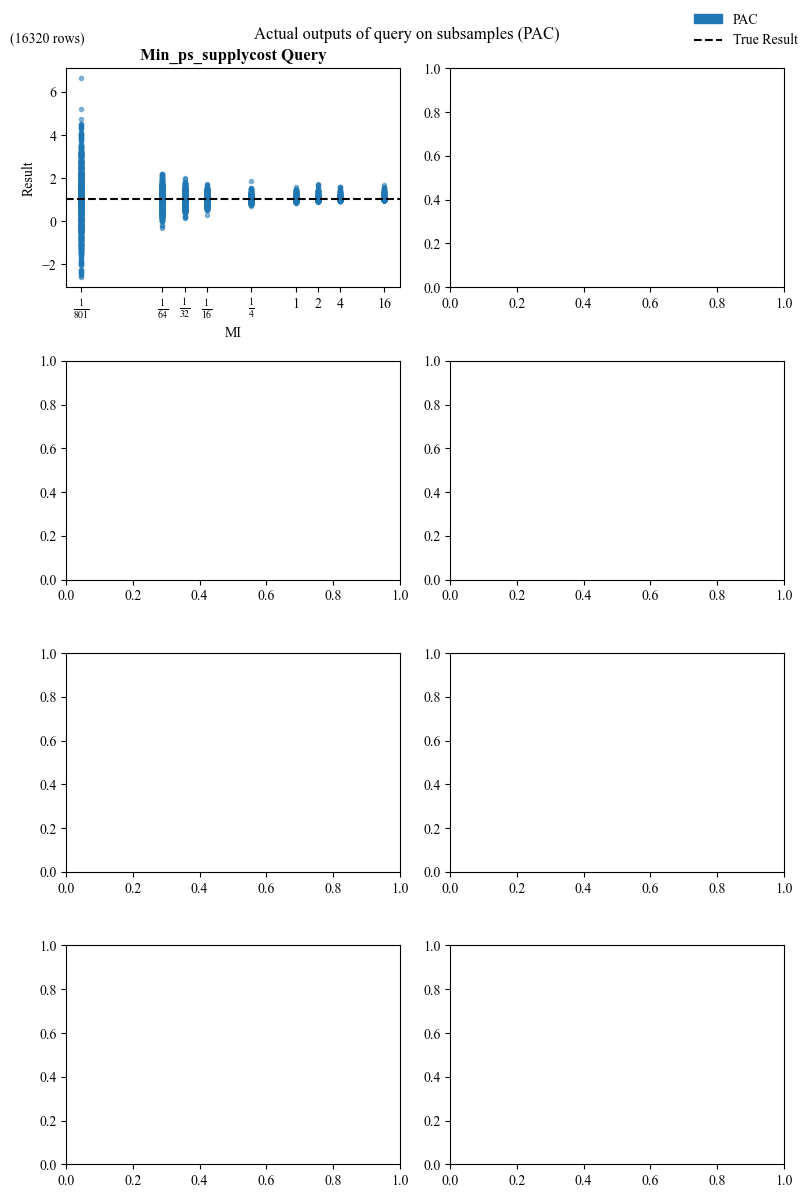

In [98]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(4, 2, figsize=(8,12))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

In [99]:
%%script echo skipping### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'dp'

    ax.scatter(dp_results_df['mi'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

skipping### Plotting the actual experiment outputs used (DP)


In [100]:
%%script echo skipping### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.linewidth = 0.25

    # correct answer
    ax.axhline(y=true_result[i], color='gray', linestyle='--', label='True Result')

    for mi in MI_OPTIONS: # categorical variable
        position = MI_OPTIONS.index(mi) * 2

        TYPE = 'pac'

        pac_style = {
            'boxprops': dict(facecolor=PAC_LIGHT),
            'medianprops': dict(color='black')
        }
        
        # mi = mi and query is correct
        d = df[df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **pac_style)

        position += 1
        TYPE = 'dp'

        dp_style = {
            'boxprops': dict(facecolor=DP_LIGHT),
            'medianprops': dict(color='black')
        }

        # mi = mi and query is correct
        d = dp_results_df[dp_results_df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **dp_style)
    
    
    
    # override xticks, one for each pair of boxplots
    # the x axis is actually artificial here to plot both PAC and DP side by side
    xticks = [0.5+2*i for i in range(len(MI_OPTIONS))]
    ax.set_xticks(xticks)

    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in MI_OPTIONS]
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='gray', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query trials (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp_vs_pac.jpg", bbox_inches='tight')
plt.show()


skipping### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))


In [101]:
df.groupby('mi').var()

,min_ps_supplycost
mi,
0.001248,1.849987
0.015625,0.166472
0.031250,0.081921
0.062500,0.041129
0.250000,0.013485
1.000000,0.007702
2.000000,0.007052
4.000000,0.004710
16.000000,0.006171


In [102]:
# tables
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap

In [103]:
print("Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)")
saved_steps_df[['mi','scale']].groupby('mi').mean()

Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)


step,scale
query,min_ps_supplycost
mi,
0.001248,1.933274
0.015625,0.154454
0.031250,0.077227
0.062500,0.038613
0.250000,0.009653
1.000000,0.002413
2.000000,0.001207
4.000000,0.000603


Comparison of how much noise is added to the data, by looking at the variance of the distributions from which noise is sampled.

In [104]:
%%script echo skipping # Wait until we have DP data to compare
dp_var_noise = {  # from pipelinedp repo, dp_basic_mean_variances.csv
    #0.00390625: 0.2784089313555703,
    #0.0078125: 0.19648087910574175,
    0.015625: 0.13837628104247293,
    0.0625: 0.06750340282072995,
    0.25: 0.03001721300521553,
    1.0: 0.004282722801885366,
    2.0: 0.004282722801885366,
    4.0: 0.004282722801885366,
    16.0: 0.004282722801885366
}
d = dp_var_noise
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(d.keys(), d.values(), marker='.', label='DP', color=DP_COLOR)
plt.xlabel('MI')
ax.set_xticks(list(d.keys()))
ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
plt.suptitle('Noise added by DP to Mean query (scale param passed to Laplace noise function)')
plt.title('DP')
plt.savefig(f"{OUTPUT_DIR}/noise_distribution_scale_meanquery_dp.jpg", bbox_inches='tight')
plt.show()

skipping # Wait until we have DP data to compare


In [105]:
#assert not any(any(saved_steps_df[['mi','scale']].groupby('mi').var().values)) # assume we are only computing scale once per MI
if ('mean' in OUTPUT_COLS):
    pac_var_noise = dict(zip(MI_OPTIONS, saved_steps_df[['mi','scale']].groupby('mi').mean()[[('scale','mean')]].to_numpy().flatten()))
    pac_var_noise

In [106]:
# Let's compute the same for PAC: what is the scale of the distribution from which noise is sampled to add to PAC?
if ('mean' in OUTPUT_COLS): 
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    d = pac_var_noise
    plt.plot(d.keys(), d.values(), marker='.', label='PAC', color=PAC_COLOR)
    plt.xlabel('MI')
    ax.set_xticks(list(d.keys()))
    ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
    plt.suptitle('Noise added by PAC to Mean query (scale param passed to Normal noise function)')
    plt.title('PAC')
    plt.savefig(f"{OUTPUT_DIR}/noise_distribution_scale_meanquery_pac.jpg", bbox_inches='tight')
    plt.show()

In [107]:
# How much of PAC error is due to sampling? Compute % error on our samples before noise was added
sample_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()]
sample_errors_df = pd.DataFrame(sample_errors, columns=OUTPUT_COLS)
sample_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Error from Subsampling (as % of true_result, without any noise being added)")
#print("First output: overall mean / Second output: grouped by MI")
display(sample_errors_df[OUTPUT_COLS].mean())
display(sample_errors_df.groupby('mi').mean())

PAC: Error from Subsampling (as % of true_result, without any noise being added)


min_ps_supplycost    3.094279
dtype: float64

,min_ps_supplycost
mi,
0.001248,3.368317
0.015625,3.388119
0.031250,3.045545
0.062500,2.823762
0.250000,2.723762
1.000000,3.217822
2.000000,3.182178
4.000000,2.747525
16.000000,3.351485


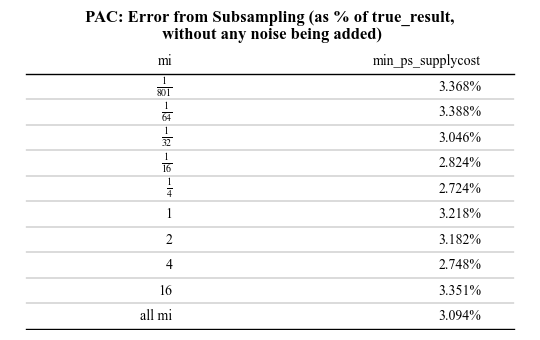

In [108]:
d=sample_errors_df.groupby('mi').mean()
d.loc['all mi'] = sample_errors_df[OUTPUT_COLS].mean()

fig, ax = plt.subplots(figsize=(5+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: Error from Subsampling (as % of true_result,\n without any noise being added)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_sample_error.jpg", bbox_inches='tight')
plt.show()

In [109]:
print("PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)")
# abs before mean
saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)


/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_69015/2429859456.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


step,abs(chosen_noise)
query,min_ps_supplycost
mi,
0.001248,1.080030
0.015625,0.319767
0.031250,0.221187
0.062500,0.153905
0.250000,0.077913
1.000000,0.040409
2.000000,0.027805
4.000000,0.019396


/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_69015/211596906.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  d = saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


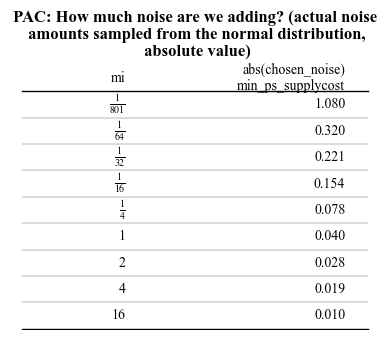

In [110]:
d = saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        title='\n'.join(c),
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: How much noise are we adding? (actual noise\n amounts sampled from the normal distribution,\n absolute value)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_chosen_noise.jpg", bbox_inches='tight')
plt.show()

In [111]:
print("Avg. value of unnoised sample used by PAC")
display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different
display(saved_steps_df[['chosen_sample']].mean().to_frame(name='all mi').T)  # sample shouldn't change with MI, so we can find the overall average

Avg. value of unnoised sample used by PAC


/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_69015/883409176.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different


step,chosen_sample
query,min_ps_supplycost
mi,
0.001248,1.04402
0.015625,1.04422
0.031250,1.04076
0.062500,1.03852
0.250000,1.03751
1.000000,1.04250
2.000000,1.04214
4.000000,1.03775


step,chosen_sample
query,min_ps_supplycost
all mi,1.041252


/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_69015/3303776140.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  d = saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean()


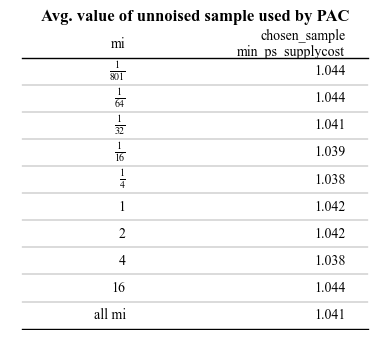

In [112]:
d = saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean()
d.loc['all mi'] = saved_steps_df[['chosen_sample']].mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        title='\n'.join(c),
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("Avg. value of unnoised sample used by PAC")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_unnoised_samples.jpg", bbox_inches='tight')
plt.show()

In [113]:
# How much total error is there in PAC? Compute % error on our samples after noise was added
total_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]
total_errors_df = pd.DataFrame(total_errors, columns=OUTPUT_COLS)
total_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Total Error (as % of true_result)")
total_errors_df.groupby('mi').mean()

PAC: Total Error (as % of true_result)


,min_ps_supplycost
mi,
0.001248,107.315658
0.015625,32.352095
0.031250,22.660462
0.062500,16.161698
0.250000,8.964530
1.000000,5.858895
2.000000,4.873486
4.000000,3.892697
16.000000,3.836343


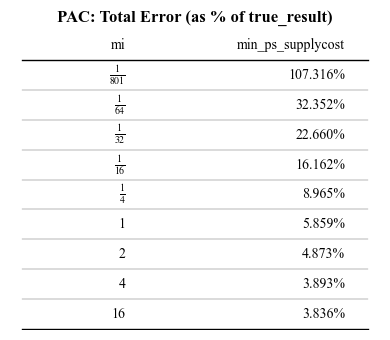

In [114]:
d=total_errors_df.groupby('mi').mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: Total Error (as % of true_result)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_total.jpg", bbox_inches='tight')
plt.show()

In [115]:
print("PAC: Increase in Avg. % error due to noise being added (as % of true_result)")
delta_error_from_noise = pd.concat(
    [
        saved_steps_df['mi'].reset_index(drop=True),
        pd.DataFrame(
            (np.array([relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]) -
             np.array([relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()])),
            columns=OUTPUT_COLS
        )
    ],
    axis=1
)
delta_error_from_noise.groupby('mi').mean()

PAC: Increase in Avg. % error due to noise being added (as % of true_result)


,min_ps_supplycost
mi,
0.001248,103.947341
0.015625,28.963976
0.031250,19.614917
0.062500,13.337936
0.250000,6.240767
1.000000,2.641073
2.000000,1.691307
4.000000,1.145172
16.000000,0.484857


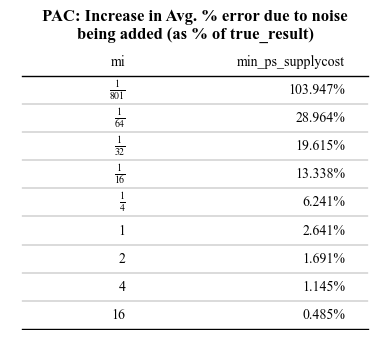

In [116]:
d=delta_error_from_noise.groupby('mi').mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        )
plt.title("PAC: Increase in Avg. % error due to noise\nbeing added (as % of true_result)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_noise.jpg", bbox_inches='tight')
plt.show()

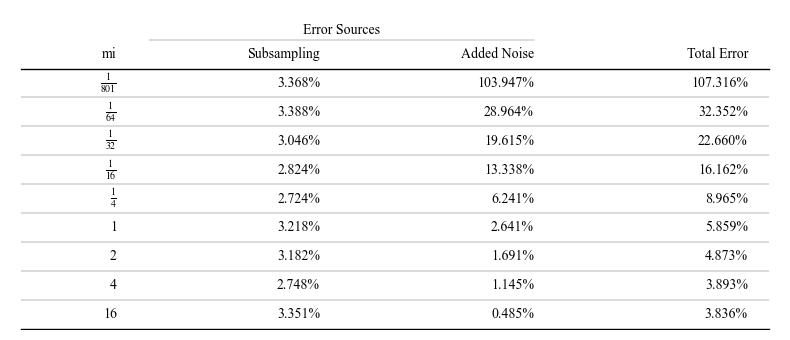

In [117]:
### Combined % Error Table
d = pd.concat([
    sample_errors_df.groupby('mi').mean(),  # % error from subsampling
    delta_error_from_noise.groupby('mi').mean(),  # % error from noise
    total_errors_df.groupby('mi').mean(),  # % total error
], axis=1)
d.columns = ['Subsampling', 'Added Noise', 'Total Error']

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        group="Error Sources",
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns[:-1]],
    ColumnDefinition(
        name=d.columns[-1],
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    )]
tbl = Table(d,
            column_definitions=col_defs,
            row_dividers=True,
            footer_divider=True,
            ax=ax,
        )
#plt.title("PAC: Error Breakdown")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()

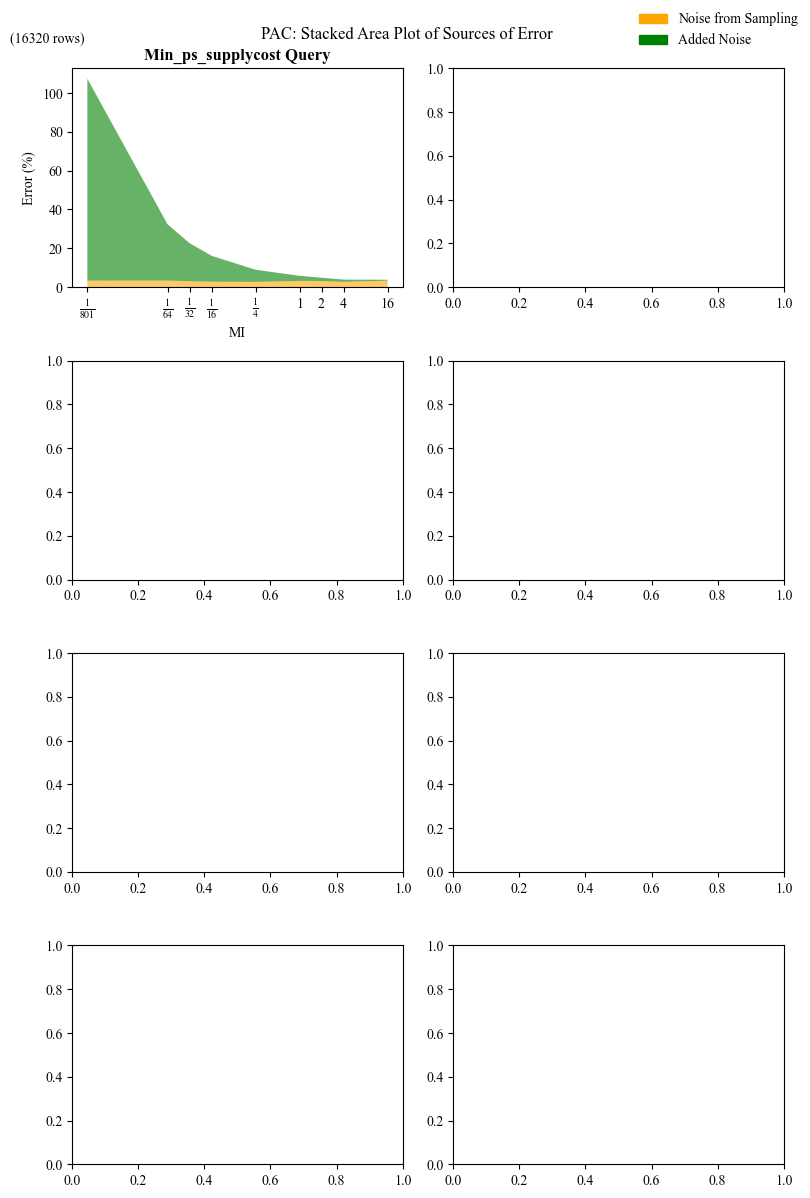

In [118]:
fig, axs = plt.subplots(4, 2, figsize=(8, 12))

psample_errors = sample_errors_df.groupby('mi').mean()
pnoise_errors = delta_error_from_noise.groupby('mi').mean()

for i, query in enumerate(OUTPUT_COLS):
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.stackplot(psample_errors.index, psample_errors[query], pnoise_errors[query], 
        labels=['Sample Error', 'Noise Error'], colors=['orange', 'green'], alpha=0.6)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)


    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Error (%)')

fig.legend(handles=[
    Patch(facecolor='orange', edgecolor='orange', label='Noise from Sampling'),
    Patch(facecolor='green', edgecolor='green', label='Added Noise'),
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("PAC: Stacked Area Plot of Sources of Error")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()

In [119]:
# relative_error_percent(38854, 3765)